In [1]:
import re
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

## Data Cleaning and Exploration

#### Bigrams

Finding the most common bigrams in your data-frame.

In [3]:
from nltk.collocations import *

Let's try it on first 10000 rows of our text

In [4]:
all_text = comments.Reply.str.cat(sep='. ')

In [5]:
all_text = nltk.word_tokenize(all_text)

In [6]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    # Find bigrams from arguments
    finder = BigramCollocationFinder.from_words(tokenized_text)
    # Find bigrams that appear 2+ times
    finder.apply_freq_filter(min_freq) 
    # Return the 10 n-grams with the highest PMI
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('Taco', 'Bell'), ('Untitled', 'Goose'), ('Sid', 'Meier'), ('Reliable', 'Delivery'), ('OTHERS', 'CLICKED'), ('vice', 'versa'), ('Hong', 'Kong'), ('Sherlock', 'Holmes'), ('Thimbleweed', 'Park'), ('Saints', 'Row')]


#### Cleaning

In [7]:
# Uncomment to use a subset of the rows.
df = comments #[comments.Key<101]
df.shape

(34367, 4)

Discard any links.

In [8]:
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Discard of \n, \t, etc. characters that do not help with prediction but might link two words together and make them indistinguishable from one another.

In [9]:
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

#### Wordcloud

In [10]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

words = df.Reply.str.cat(sep='. ')

In [11]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

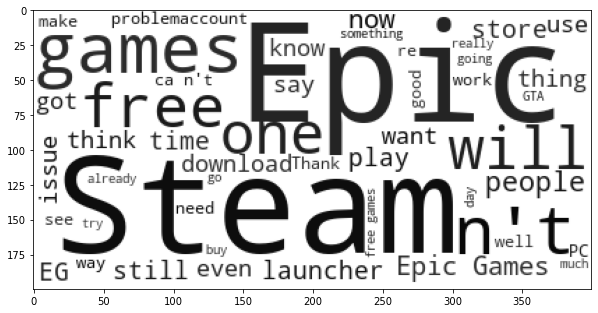

In [12]:
stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# Generate word cloud
wc.generate(words)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

## Sentiment Analysis

- ### __Sentiment Classification using Vader package__

In [13]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

# Initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

We can add sentiment scores to words manually if we want

In [15]:
new_words = {
    'Steam' : 0,
    'Epic Games' : 0,
}

sid.lexicon.update(new_words)

In [16]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

In [17]:
df[['vdr neg','vdr neu','vdr pos','vdr compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [18]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0


In [19]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound
count,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000
mean,2.657928,335.480286,0.065198,0.790132,0.141033,0.161202
std,6.106541,272.709551,0.119265,0.214190,0.190331,0.446996
min,-47.000000,0.000000,0.000000,0.000000,0.000000,-0.994700
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000
50%,1.000000,261.000000,0.000000,0.828000,0.084000,0.000000
75%,3.000000,526.000000,0.095000,1.000000,0.206000,0.510600
max,212.000000,995.000000,1.000000,1.000000,1.000000,0.999100


- ### Sentiment Classification using Textblob package

In [20]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [21]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [22]:
df[['TB Classification','TB pos','TB neg']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [23]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0,neg,0.279181,0.720819
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0,pos,0.667773,0.332227
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0,pos,0.935340,0.064660


In [24]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB pos,TB neg
count,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,3.436700e+04,3.436700e+04
mean,2.657928,335.480286,0.065198,0.790132,0.141033,0.161202,5.686343e-01,4.313657e-01
std,6.106541,272.709551,0.119265,0.214190,0.190331,0.446996,2.682720e-01,2.682720e-01
min,-47.000000,0.000000,0.000000,0.000000,0.000000,-0.994700,1.682455e-07,8.749978e-27
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000,3.876036e-01,2.163452e-01
50%,1.000000,261.000000,0.000000,0.828000,0.084000,0.000000,5.560954e-01,4.439046e-01
75%,3.000000,526.000000,0.095000,1.000000,0.206000,0.510600,7.836548e-01,6.123964e-01
max,212.000000,995.000000,1.000000,1.000000,1.000000,0.999100,1.000000e+00,9.999998e-01


In [25]:
df['TB Classification'].value_counts()

pos    21256
neg    13111
Name: TB Classification, dtype: int64

- ### Sentiment Classification using Self-Trained Classifier Module for Kaggle

In [26]:
import import_ipynb
%run Kaggle_Trained_Classifier.ipynb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# Transform the 'Reply' so it can be passed to the Self-Trained Classifier
Z = vectorizer.transform(df['Reply'])

In [28]:
# Predict the Sentiment based on our reply
predicted2 = nb.predict(Z)

In [29]:
# Look at the size of the prediction result, make sure it is the same as the dataframe's
predicted2.shape

(34367,)

In [30]:
df.shape

(34367, 11)

In [31]:
# Add the Self-Trained Classifier's Classification to the dataframe
df['Classification for Kaggle'] = predicted2

In [32]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg,Classification for Kaggle
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0,neg,0.279181,0.720819,neutral
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0,pos,0.667773,0.332227,neutral
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0,pos,0.935340,0.064660,neutral


In [33]:
df['Classification for Kaggle'].value_counts()

neutral     19140
negative     8166
positive     7061
Name: Classification for Kaggle, dtype: int64

## Analysis
- ### __Positive / Negative Sentiments Ratio__

Using the Textblob package, we can see that the Epic Games Store reddit has a mixed sentiment response on posts. 39% bad sentimes and 61% good sentiment.

Using our own trained classification module, there seems to be more Negative sentiments compared to Positive ones. 23% Negative response and 21% Positive sentimes. But if we set aside the Neutral Sentimes, this looks like a very mixed sentiment.

In [34]:
df['Classification for Kaggle'].value_counts(normalize=True) * 100

neutral     55.692961
negative    23.761166
positive    20.545872
Name: Classification for Kaggle, dtype: float64

In [35]:
df['TB Classification'].value_counts(normalize=True) * 100

pos    61.850031
neg    38.149969
Name: TB Classification, dtype: float64

- ### Analysing Compound Sentiment Score Overtime

In [36]:
# Importing matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
overTime = df.drop(["Reply","Upvote","Key","vdr neg","vdr neu","vdr pos","TB Classification","TB pos","TB neg","Classification for Kaggle"], axis =1)

In [38]:
overTime.head(5)

,Time,vdr compound
0,2020-05-15 03:24:53,0.0000
1,2020-05-15 03:44:36,0.0000
2,2020-05-15 03:55:30,0.0000
3,2020-05-15 05:29:58,-0.3089
4,2020-05-15 03:34:30,0.4211


In [39]:
# Set 'Time' as Index
# This is done to allow grouping by DatetimeIndex
over_time = overTime.set_index(pd.DatetimeIndex(overTime['Time']))

In [40]:
over_time.head()

,Time,vdr compound
Time,,
2020-05-15 03:24:53,2020-05-15 03:24:53,0.0000
2020-05-15 03:44:36,2020-05-15 03:44:36,0.0000
2020-05-15 03:55:30,2020-05-15 03:55:30,0.0000
2020-05-15 05:29:58,2020-05-15 05:29:58,-0.3089
2020-05-15 03:34:30,2020-05-15 03:34:30,0.4211


In [41]:
# Group values by Month
g = over_time.groupby(pd.Grouper(freq="M")) 

In [42]:
# Sum the values of each Month
data_sum = g.sum()

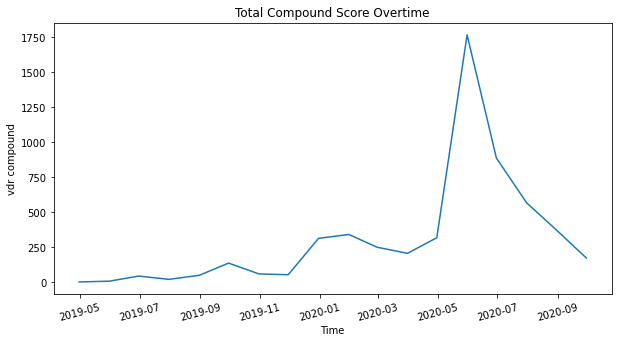

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_sum.index, y="vdr compound", data=data_sum)
plt.xticks(rotation=15)
plt.title('Total Compound Score Overtime')
plt.show()

In [44]:
# Find the average values of each month
data_mean = g.mean()

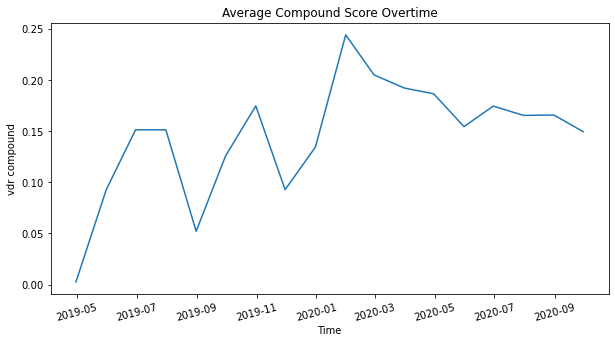

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_mean.index, y="vdr compound", data=data_mean)
plt.xticks(rotation=15)
plt.title('Average Compound Score Overtime')
plt.show()